In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv, GATConv, Linear, HGTConv, HeteroConv, GCNConv, to_hetero
from tqdm import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

2.0.1


### Heterogeneous Graph

As a guiding example, we take a look at the heterogeneous ogbn-mag network from the dataset suite:


The given heterogeneous graph has 1,939,743 nodes, split between the four node types author, paper, institution and field of study. It further has 21,111,007 edges, which also are of one of four types:

![alt text](./hgex.png)

- writes: An author writes a specific paper
- affiliated with: An author is affiliated with a specific institution
- cites: A paper cites another paper
- has topic: A paper has a topic of a specific field of study

The task for this graph is to infer the venue of each paper (conference or journal) given the information stored in the graph.

## HeteroData
Data object of type torch_geometric.data.HeteroData, allow to define node feature tensors, edge index tensors and edge feature tensors individually for each type
Node types are identified by a single string while edge types are identified by using a triplet (source_node_type, edge_type, destination_node_type) of strings: the edge type identifier and the two node types between which the edge type can exist. As such, the data object allows different feature dimensionalities for each type.

In [29]:
dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]
num_of_class = dataset.num_classes
print(data)


HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 10792672] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] },
  (institution, rev_affiliated_with, author)={ edge_index=[2, 1043998] },
  (paper, rev_writes, author)={ edge_index=[2, 7145660] },
  (field_of_study, rev_has_topic, paper)={ edge_index=[2, 7505078] }
)
dict_items([('paper', tensor([[-0.0954,  0.0408, -0.2109,  ...,  0.0616, -0.0277, -0.1338],
        [-0.1510, -0.1073, -0.2220,  ...,  0.3458, -0.0277, -0.2185],
        [-0.1148, -0.1760, -0.2606,  ...,  0.1731, -0.1564, -0.2780],
        ...,
        [ 0.0228, -0.0865,  0.0981,  ..., -0.0547, 

In [34]:
print(next(iter(data.x_dict.items()))

('paper',
 tensor([[-0.0954,  0.0408, -0.2109,  ...,  0.0616, -0.0277, -0.1338],
         [-0.1510, -0.1073, -0.2220,  ...,  0.3458, -0.0277, -0.2185],
         [-0.1148, -0.1760, -0.2606,  ...,  0.1731, -0.1564, -0.2780],
         ...,
         [ 0.0228, -0.0865,  0.0981,  ..., -0.0547, -0.2077, -0.2305],
         [-0.2891, -0.2029, -0.1525,  ...,  0.1042,  0.2041, -0.3528],
         [-0.0890, -0.0348, -0.2642,  ...,  0.2601, -0.0875, -0.5171]]))

## Using the Heterogeneous Convolution Wrapper

The heterogeneous convolution wrapper torch_geometric.nn.conv.HeteroConv allows to define custom heterogeneous message and update functions to build arbitrary MP-GNNs for heterogeneous graphs from scratch. While the automatic converter to_hetero() uses the same operator for all edge types, the wrapper allows to define different operators for different edge types.

In [4]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = HeteroConv({
            ('paper', 'cites', 'paper'): GCNConv(-1, hidden_channels),
            ('author', 'writes', 'paper'): SAGEConv((-1, -1), hidden_channels),
            ('paper', 'rev_writes', 'author'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')

        self.conv2 = HeteroConv({
            ('paper', 'cites', 'paper'): SAGEConv((-1, -1), hidden_channels),
            ('author', 'writes', 'paper'): SAGEConv((-1, -1), hidden_channels),
            ('paper', 'rev_writes', 'author'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')

        self.conv3 = HeteroConv({
            ('paper', 'cites', 'paper'): GCNConv(-1, hidden_channels),
            ('author', 'writes', 'paper'): SAGEConv((-1, -1), hidden_channels),
            ('paper', 'rev_writes', 'author'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}

        return self.lin(x_dict['paper'])

## Heterogeneous Operators

PyG provides operators (e.g., torch_geometric.nn.conv.HGTConv), which are specifically designed for heterogeneous graphs. These operators can be directly used to build heterogeneous GNN models 

In [5]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, hidden_channels2, hidden_channels3, out_channels, num_heads):
        super().__init__()

        self.lin_paper = Linear(128, hidden_channels)
        self.lin_author = Linear(128, hidden_channels)
        self.lin_institution = Linear(128, hidden_channels)
        self.lin_field_of_study = Linear(128, hidden_channels)

        self.conv1 = HGTConv(hidden_channels, hidden_channels2, data.metadata(),
                       num_heads, group='sum')
        self.conv2 = HGTConv(hidden_channels2, hidden_channels3, data.metadata(),
                       num_heads, group='sum')

        self.lin = Linear(hidden_channels3, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            if node_type == 'paper':
                x_dict[node_type] = self.lin_paper(x).relu_()
            if node_type == 'author':
                x_dict[node_type] = self.lin_author(x).relu_()
            if node_type == 'institution':
                x_dict[node_type] = self.lin_institution(x).relu_()
            if node_type == 'field_of_study':
                x_dict[node_type] = self.lin_field_of_study(x).relu_()

        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = self.conv2(x_dict, edge_index_dict)

        return self.lin(x_dict['paper'])

In [37]:
def train():
    model.train()
    i=0
    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        i+=1
        if i == 100:
            break    # break here
        batch.to(device)
        optimizer.zero_grad()
        batch_size = batch['paper'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        #loss = criterion(out[:batch_size], batch['paper'].y[:batch_size])
        loss = torch.nn.functional.cross_entropy(out[:batch_size], batch['paper'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

def test():
    model.eval()

    total_examples = total_loss = 0
    for batch in tqdm(test_loader):
        batch.to(device)
        optimizer.zero_grad()
        batch_size = batch['paper'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)

        pred = out.argmax(dim=1)
        correct = pred[:batch_size] == batch['paper'].y[:batch_size]
        accs = int(correct.sum()) / int(batch_size)
    return accs


    return total_loss / total_examples

In [19]:
train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('paper', data['paper'].train_mask),
)

test_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('paper', data['paper'].test_mask),
)

In [38]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
#criterion = torch.nn.functional.cross_entropy() 
numofep = 4

In [39]:
loss_HeteroGNN = []
acc_HeteroGNN = []
model= HeteroGNN(hidden_channels=64, out_channels=num_of_class)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
model.to(device)
for i in range(1,numofep):
    print(f"Epoch {i}")
    loss = train()
    print(f"Current losso is: {loss}")
    loss_HeteroGNN.append(loss)
    accuracy = test()
    print(f"Current accuracy is: {accuracy}")
    acc_HeteroGNN.append(accuracy)

Epoch 1


  2%|▏         | 99/4919 [00:11<09:22,  8.57it/s] 


Current losso is: 4.206149958600902


100%|██████████| 328/328 [00:24<00:00, 13.60it/s]


Epoch 2


  2%|▏         | 99/4919 [00:10<08:20,  9.63it/s]


Current losso is: 3.3850076029999085


  2%|▏         | 7/328 [00:00<00:27, 11.78it/s]


KeyboardInterrupt: 

In [23]:
loss_HGT = []
acc_HGT= []
model = HGT(hidden_channels=64, hidden_channels2=32, hidden_channels3=16, out_channels=num_of_class, num_heads=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
model.to(device)
for i in range(1,numofep):
    print(f"Epoch {i}")
    loss = train()
    print(f"Current losso is: {loss}")
    loss_HGT.append(loss)
    accuracy = test()
    print(f"Current accuracy is: {accuracy}")
    acc_HGT.append(accuracy)

Epoch 1


  2%|▏         | 99/4919 [00:11<09:09,  8.77it/s]


Current losso is: 4.873224330670906


  2%|▏         | 99/4919 [00:11<09:11,  8.74it/s]


Epoch 2


  2%|▏         | 99/4919 [00:11<09:11,  8.75it/s]


Current losso is: 3.9356415777495415


  2%|▏         | 99/4919 [00:11<09:11,  8.74it/s]


Epoch 3


  2%|▏         | 99/4919 [00:11<09:12,  8.72it/s]


Current losso is: 3.5003390408525563


  2%|▏         | 99/4919 [00:11<09:09,  8.77it/s]


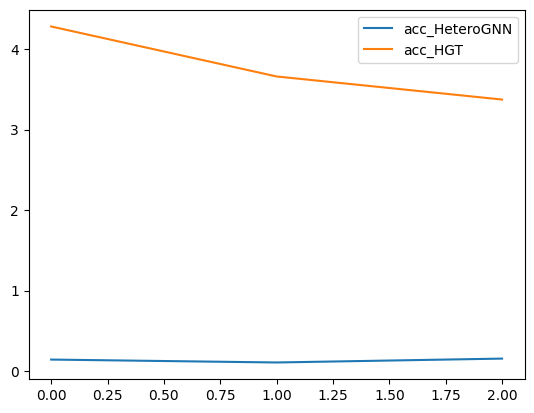

In [24]:
import matplotlib.pyplot as plt
# plot lines
plt.plot(loss_HeteroGNN, label="loss_HeteroGNN")
plt.plot(loss_HGT, label="loss_HGT")
plt.legend()
plt.savefig("loss.png")

plt.close()

plt.plot(acc_HeteroGNN, label="acc_HeteroGNN")
plt.plot(acc_HGT, label="acc_HGT")
plt.legend()
plt.savefig("acc.png")